Scientific Computing 2021
Kimi Cardoso Kreilgaard
TWN176

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt 
import scipy.optimize as sp # to check functions
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Import helper functions
from LJhelperfunctions import *

## A

In [3]:
# Get the function V from the LJ function that generates V
V_func = LJ(sigma=SIGMA, epsilon=EPSILON)

In [4]:
# Define the function that calculates V for two particles
def V_two_particles(x):
    
    # Define coordinates for the particles
    x0 = np.array([x,0,0])
    x1 = np.array([0,0,0])
    
    # Calculate potential
    points = np.stack((x0,x1))
    pot = V_func( points )
    
    return pot

# Define the function that calculates V for four particles
def V_four_particles(x):
    
    # Define coordinates for the particles
    x0 = np.array([x,0,0])
    x1 = np.array([0,0,0])
    x2 = np.array([14,0,0])
    x3 = np.array([7,3.2,0])
    
    # Calculate potential
    points = np.stack((x0,x1,x2,x3))
    pot = V_func( points )
    
    return pot

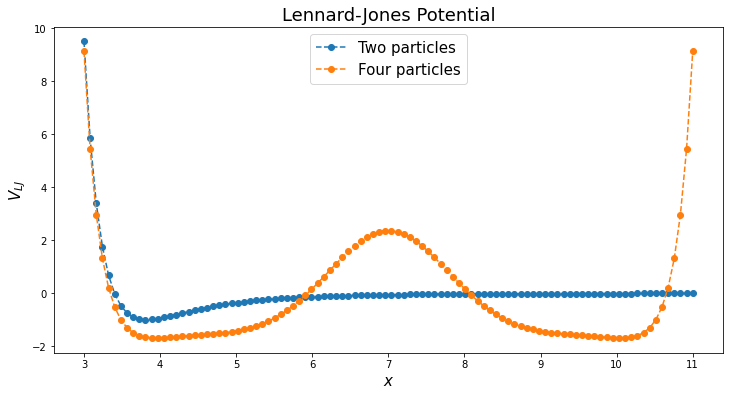

In [5]:
# Let x range from 3 to 11, and make empty array to store strenght of potential in
x_arr = np.linspace(3,11,100)
V2_arr = np.zeros_like(x_arr) 
V4_arr = np.zeros_like(x_arr) 

# Calculate potential for each x
for x, i in zip(x_arr, np.arange(len(x_arr))):
    
    # Two particles
    potential2 = V_two_particles(x)
    V2_arr[i] = potential2
    
    # Four particles
    potential4 = V_four_particles(x)
    V4_arr[i] = potential4
    
# Plot it
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x_arr, V2_arr, 'C0o--', label='Two particles')
ax.plot(x_arr, V4_arr, 'C1o--', label='Four particles')
ax.set_xlabel(r'$x$', fontsize=15)
ax.set_ylabel(r'$V_{LJ}$', fontsize=15)
ax.set_title('Lennard-Jones Potential', fontsize=18)
ax.legend(fontsize=15)

plt.show()

## B

In [6]:
# Define the function
def bisection_root(f, a, b, tol=1e-13):
    """
    INPUTS:
    f = function to find a root of
    a,b = limits of interval in which to find a root
    tol = tolerance so that |f(x0)|<tol
    
    OUTPUTS:
    m = x coordinate of the root (within the tolerance) / midpoint
    n_calls = number of times the function is called, i.e. the number of times the midpoint is evaluated
    """
    
    # Check that f crosses the x axis in the interval
    if np.sign(f(a)) == np.sign(f(b)):
        print("The interval is not guaranteed to hold a root according to the intermediate value theorem.")
        return
    
    # Get first midpoint and evaluate function at start and mid
    m = a + (b-a) / 2
    y_m = f(m)
    y_a = f(a)
    
    # Start counter with two for the functions called
    n_calls = 2
    
    # Continue with reducing the interval, until tolerated error is obtained
    while abs(y_m) > tol:
    
        # Choose which half of the interval to cut
        if np.sign( y_a ) == np.sign( y_m ):
            a = m
            y_a = y_m
            
        else:
            b = m
            y_b = y_m
    
        # Get the new midpoint
        m = a + (b-a) / 2
        y_m = f(m)
        
        # Add +1 to counter
        n_calls += 1
             
    return m, n_calls

n + 3 i alt, så 3 skal være udenfor loopet

In [7]:
# Test it
x, n_calls = bisection_root(V_two_particles, 2, 6)

# Print results
print(f'The root was found to be {x} with {n_calls} calls. Sigma is {SIGMA}')

The root was found to be 3.4010000000000105 with 47 calls. Sigma is 3.401


## C

In [8]:
# Define the derivative for df
def dV_two_particles(r):
    return 4*EPSILON*( (6*SIGMA**6)/r**7 - (12*SIGMA**12)/r**13 ) 

In [9]:
# Define the function
def newton_root(f, df, x0, tol=1e-12, max_it=100):
    """
    INPUTS:
    f = function to find a root of
    df = derivative of f
    x0 = initial guess of root
    tol = tolerance so that |f(x*)|<tol
    max_it = 
    
    OUTPUT:
    x = x coordinate of the root (within the tolerance)
    n_calls = number of times the function or derivative is called
    """
    
    # Make sure max_it is an integer, start with initial guess and n_calls as zero
    max_it, x, n_calls = int(max_it), x0, 0
    
    # Loop over max iterations
    for i in range(max_it):

        # Calculate y value
        y = f(x)
        
        # Break if tolerance is satisfied
        if abs(y) < tol:
            
            # Add to counter (only f is evaluated)
            n_calls +=1
            return x, n_calls
        
        # Get new x
        dy = df(x)
        x = x - y/dy
        
        # Add to counter (both f and df are evaluated)
        n_calls += 2
    
    print('Maximum numbber of iteration reached at n_calls={max_it}')
    
    return x, n_calls

In [10]:
# Test it
x, n_calls = newton_root(V_two_particles, dV_two_particles, 2, tol=1e-12)

# Print results
print(f'The root was found to be {x} with {n_calls} calls. Sigma is {SIGMA}')

The root was found to be 3.400999999999998 with 25 calls. Sigma is 3.401


## D

In [11]:
def bisection_step(f, a, b, n_calls):
    """
    Function that performs one iteration of bisection, aka it takes an interval and shrinks it.
    Furthermore it updates n_calls with how many times the function f is called
    """
    # Get midpoint and evaluate function at start and mid
    m = a + (b-a) / 2
    y_m = f(m)
    y_a = f(a)
    
    # Choose which half of the interval to cut
    if np.sign( y_a ) == np.sign( y_m ):
        a = m    
    else:
        b = m
    
    # Update counter
    n_calls += 2
    
    return a, b, n_calls

def newton_rhapson_step(y, dy, x0):
    """
    Function that performs one iteration of newton rhapson, 
    aka it takes an initial guess and returns an estimate of the root
    
    y = f(x0) will already be evaluated to check tolerance when combining in one hybrid function
    dy = df(x0) also already evaluated to check if it is equal to zero
    """
    x = x0 - y/dy
    
    return x

In [12]:
def hybrid_root(f, df, x0, a, b, tol):
    
    # Check that f crosses the x axis in the interval
    if np.sign(f(a)) == np.sign(f(b)):
        print("The interval is not guaranteed to hold a root according to the intermediate value theorem.")
        return
    
    # Evaluate the function on the initial guess and start counter
    m = x0
    y_m = f(m)
    n_calls = 1
    
    # Check tolerance
    while abs(y_m) > tol:

        # Calculate derivative
        dy = df(m)
        n_calls += 1
        
        # If derivative is zero perform one bisection iteration
        if dy == 0:
            a, b, n_calls = bisection_step(f, a, b, n_calls)
            
            # Get midpoint m
            m = a + (b-a) / 2

        else:
            # If not perform one iteration of newton-rhapson
            m = newton_rhapson_step(y_m, dy, m) # equivalent to: m = m - y_m/dy
            
            # Check that the new estimate of the root m, is not outside the interval a,b
            if m > a and m < b:
                
                # Get function values and update counter
                y_a = f(a)
                n_calls += 1
            
                # Shrink the interval depending on sign
                if np.sign(y_a) == np.sign(y_m):
                    a = m  
                else:
                    b = m
                    
            # If outside the interval use bisection instead
            else:
                a, b, n_calls = bisection_step(f, a, b, n_calls)
                
                # Get midpoint m
                m = a + (b-a) / 2
        
        # Update function value and n_calls
        y_m = f(m)
        n_calls += 1
    
    return m, n_calls

In [13]:
# Test it
x, n_calls = hybrid_root(V_two_particles, dV_two_particles, 2, 2, 6, tol=1e-13)

# Print results
print(f'The root was found to be {x} with {n_calls} calls. Sigma is {SIGMA}')

The root was found to be 3.400999999999998 with 37 calls. Sigma is 3.401


## E

In [14]:
# Get the gradient of Argon
gradV_func = LJgradient(sigma=SIGMA, epsilon=EPSILON)

# Define the function that calculates gradV for two particles
def gradV_two_particles(x):
    
    # Define coordinates for the particles
    x0 = np.array([x,0,0])
    x1 = np.array([0,0,0])
    
    # Calculate potential
    points = np.stack((x0,x1))
    gradV = gradV_func( points )
    
    return gradV

In [15]:
x_arr = np.linspace(3,10,1000)
gradx_arr = np.zeros_like(x_arr)
grady_arr = np.zeros_like(x_arr)
gradz_arr = np.zeros_like(x_arr)

for x, i in zip(x_arr, np.arange(len(x_arr))): 
    
    grad = gradV_two_particles(x)
    
    if i == 0:
        print(grad)
    
    gradx_arr[i], grady_arr[i], gradz_arr[i] = grad[0] #get gradient evaluated in x0

[[-54.9536532   0.          0.       ]
 [ 54.9536532   0.          0.       ]]


The first row is the gradient (x-component, y-component, z_component) for the first particle x0. The second row is the same for particle at position x1. oth particles have 0 as y and z component. Thus there will only be attraction along the x-line - aka why there is a nonzero component in the x direction for both particles. These are equal and opposite since they attract each other.

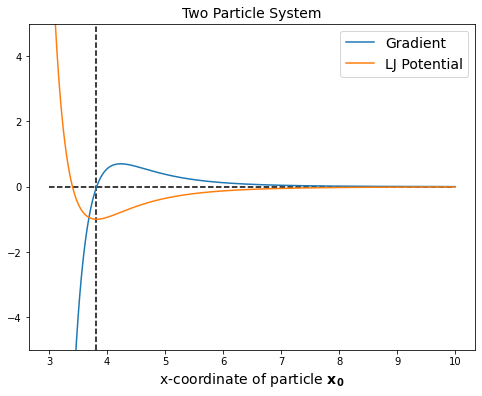

In [16]:
# Get values of potential in same interval
V_arr = np.zeros_like(x_arr) 

# Calculate potential for each x
for x, i in zip(x_arr, np.arange(len(x_arr))):
    potential = V_two_particles(x)
    V_arr[i] = potential

# Plot the nonzero component for x0
fig, ax = plt.subplots(figsize=(8,6))

# Gradient
ax.plot(x_arr, gradx_arr, '-', label='Gradient')

# Potential
ax.plot(x_arr,V_arr,'-',label='LJ Potential')
ax.hlines(0,3,10,color='k', linestyle='dashed')
ax.vlines(3.81,-5,5,color='k', linestyle='dashed')

ax.set_title('Two Particle System', fontsize=14)
ax.set_xlabel(r'x-coordinate of particle $\mathbf{x_0}$', fontsize=14)
ax.legend(fontsize=14)

ax.set_ylim(-5,5)

plt.show()

In [17]:
# Define the function that calculates gradV for FOUR particles
def gradV_four_particles(x):
    
    # Define coordinates for the particles
    x0 = np.array([x,0,0])
    x1 = np.array([0,0,0])
    x2 = np.array([14,0,0])
    x3 = np.array([7,3.2,0])
    
    # Calculate potential
    points = np.stack((x0,x1,x2,x3))
    gradV = gradV_func( points )
    
    return gradV

[[-5.52144571e+01 -2.07125638e-01  0.00000000e+00]
 [ 5.49325687e+01 -9.47811027e-03  0.00000000e+00]
 [ 2.29813708e-02 -9.47811027e-03  0.00000000e+00]
 [ 2.58907047e-01  2.26081858e-01  0.00000000e+00]]


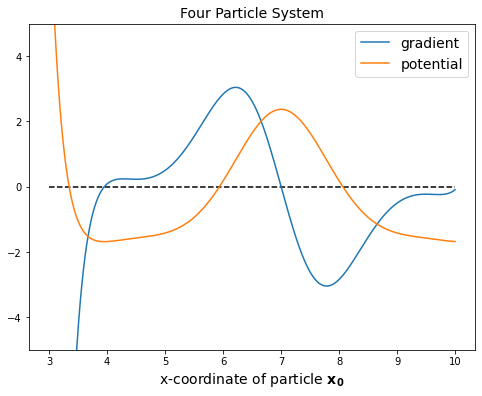

In [18]:
# Make an x_arr and empty lists to store values
x_arr = np.linspace(3,10,1000)
V_arr = np.zeros_like(x_arr) 
gradx_arr = np.zeros_like(x_arr)
grady_arr = np.zeros_like(x_arr)
gradz_arr = np.zeros_like(x_arr)

# Loop de loop
for x, i in zip(x_arr, np.arange(len(x_arr))): 
    
    # Get potential
    potential = V_four_particles(x)
    V_arr[i] = potential
    
    # Get gradient
    grad = gradV_four_particles(x)
    
    # Print one gradient to check values
    if i == 0:
        print(grad)
    
    # Append values
    gradx_arr[i], grady_arr[i], gradz_arr[i] = grad[0]
    
# Plot the nonzero component for x0
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_arr, gradx_arr, '-', label='gradient')
ax.plot(x_arr,V_arr,'-',label='potential')
ax.hlines(0,3,10,color='k', linestyle='dashed')
ax.set_ylim(-5,5)
ax.legend(fontsize=14)
ax.set_title('Four Particle System', fontsize=14)
ax.set_xlabel(r'x-coordinate of particle $\mathbf{x_0}$', fontsize=14)

plt.show()

## F

In [19]:
# Define the function
def flat_bisection_root(f, a, b, tol=1e-13):
    """
    INPUTS:
    f = function to find a root of
    a,b = limits of interval in which to find a root
    tol = tolerance so that |f(x0)|<tol
    
    OUTPUTS:
    m = x coordinate of the root (within the tolerance) / midpoint
    n_calls = number of times the function is called, i.e. the number of times the midpoint is evaluated
    """
    
    # Check that f crosses the x axis in the interval
    if ( np.sign(f(a)) == np.sign(f(b)) ).all():
        print("The interval is not guaranteed to hold a root according to the intermediate value theorem.")
        return
    
    # Get first midpoint and evaluate function at start and mid
    m = a + (b-a) / 2
    y_m = f(m)
    y_a = f(a)
    
    # Start counter with two for the functions called
    n_calls = 2
    
    # Continue with reducing the interval, until tolerated error is obtained
    while abs(b-a) > tol:
        #print(m)
        # Choose which half of the interval to cut
        if ( np.sign( y_a ) == np.sign( y_m ) ).all():
            a = m
            y_a = y_m
            
        else:
            b = m
            y_b = y_m
    
        # Get the new midpoint
        m = a + (b-a) / 2
        y_m = f(m)
        
        # Add +1 to counter
        n_calls += 1
             
    return m, n_calls

In [20]:
# Lets first make some helper functions
def line_function(F, x0, d):
    """
    Returns a function, F_restricted, which calculates F along the line segment defined
    by x0+alpha*d.
    """
    def F_restricted(alpha):
        
        # A line through space
        line = x0 + alpha*d
        
        # Calculate F along the line
        return F(line)
    
    return F_restricted

# And here is a function to give us the directional derivative along a line. 
def directional_derivative_line_function(F, x0, d):
    gradf_restricted = line_function(F, x0, d)
    
    def directional_derivative(alpha):
        return d @ gradf_restricted(alpha)
    
    return directional_derivative

In [21]:
def line_search(F, x0, d, alpha_min, alpha_max, tol, max_it=100):
    
    """
    INPUTS:
    F = function to find the 0 point of (should be a gradient thus a zero-point equals a stationary point)
    x0 = initial guess, a point in space, in N dimensions this would be a N-dim vector
    d = direction that defines the line segment along with the point x0. Also a N-dim vector.
    alpha_min, alpha_max = defines the search space for alpha (alpha parametrizes the line segment)
                           this will correspond to a and b in the bisection method.
    tol = the tolerance to be passed to bisection aka how close to zero f(x0) should be in the end 
          (convergence criterion)
    max_it = maximum number of iterations ????
    
    OUTPUTS:
    alpha = the value of alpha it has converged on
    n_calls = number of times F is called
    """
    
    # Flatten stuff
    x0_flat = x0.flatten()
    d_flat = d.flatten()

    # Get function defining the directional derivative d @ F(x0+alpha*d)
    directional_derivative_func = directional_derivative_line_function(F, x0_flat, d_flat)

    # Use bisection to find the zero point of the directional derivative
    alpha, n_calls = flat_bisection_root(directional_derivative_func, alpha_min, alpha_max, tol=tol)
    
    return alpha, n_calls

In [22]:
### Test it ###

# Define the initial point
x0 = np.array([[4,0,0],[0,0,0],[14,0,0],[7,3.2,0]])

# Define direction from steepest descent
d = -gradV_func(x0)

# Define alpha interval
alpha_min, alpha_max = 0,1

# Use line search
alp, calls = line_search(flat_gradV, x0, d, alpha_min, alpha_max, tol=1e-13)
print(f'Found alpha={alp} with {calls} calls to the function.')

Found alpha=0.45170705184219173 with 46 calls to the function.


## G

In [23]:
def golden_section_min(f, a, b, tol=1e-3):
    """
    Notice that f is one dimensional. You can use line_function with flat_V to get it to that.
    """
    
    # Define tau
    tau = (np.sqrt(5)-1)/2
    
    # Compute initial points x1 and x2 within the interval [a,b] from tau (golden ratio)
    x1 = a + (1-tau)*(b-a)
    f1 = f(x1)

    x2 = a + tau*(b-a)
    f2 = f(x2)
    
    # Start counter of calls to the function with 2 (from evaluating f1 and f2)
    n_calls = 2
    
    # Perform the search until the tolerance is satisfied
    while abs(b-a) > tol:
        
        ### Check which subinterval to discard to find minima ###

        # Continue with the "right" interval, see p. 270 for illustration
        if f1 > f2:
            
            # Shrink interval
            a = x1
            
            # Let the right midpoint (formely x2) be x1, since it is now the left midpoint
            x1 = x2
            f1 = f2
            
            # Find x2 from tau
            x2 = a + tau*(b-a)
            f2 = f(x2)
        
        # Continue with the "left" interval
        else:
            
            # Shrink interval
            b = x2
            
            # Let the left midpoint (formely x1) be x2, since it is now the right midpoint
            x2 = x1
            f2 = f1
            
            # Find x1 from tau
            x1 = a + (1-tau)*(b-a)
            f1 = f(x1)
        
        # We call the function once for each iteration
        n_calls += 1
        
        # Let the optimized x, x_opt, be the midpoint between the now found small interval [a,b]
        x_opt = a + (b-a) / 2
    
    return x_opt, n_calls

In [24]:
# Test it on example in (f) see if we get same alpha
f = line_function( F=flat_V, x0=x0.flatten(), d=-gradV_func(x0).flatten() )

alp, calls = golden_section_min(f, 0,1)

# Print results
print(f'The minima was found to be {alp} with {calls} calls.')

The minima was found to be 0.4516693913190848 with 17 calls.


In [25]:
# Find distance with golden section
r0, calls = golden_section_min(V_two_particles, 2,6)
print(f'The optimal distance was found to be {r0} with {calls} calls.')

The optimal distance was found to be 3.8172876299217666 with 20 calls.


## H

In [26]:
def BFGS(f, gradf, x0, tol=1e-6, max_it=10000):
    
    # Initial guess of the positions
    x = x0
    
    # Define identity matrix of appropriate size
    I = np.eye(len(x0))
    
    # Initialise inverted Hessian approximation with I
    B_inv = I
    
    # Initial gradient
    y = gradf(x)

    # Start counter of calls to the functions f and gradf with 1
    n_calls = 1
    
    # Let the converged status be true. If max_it is hit we change this to false.
    converged = True

    # Start loop, should stop when max_it is reached or at convergence
    # Convergence is chosen to be the norm since a small norm means a small step
    while np.linalg.norm(y) > tol and n_calls < max_it: 
        
        # Get direction from steepest descent
        s = - np.dot(B_inv,y)
        
        # Get the next positions
        x_new = x + s
        
        # Get the new gradient and update n_calls
        y_new = gradf(x_new)
        dy = y_new - y 
        n_calls += 1
        
        # Get the new approximation to the inverse hessian (formula from section "algortihm" here:
        # https://en.wikipedia.org/wiki/Broyden–Fletcher–Goldfarb–Shanno_algorithm)
        ro = 1.0 / (np.dot(dy, s))
        A1 = I - ro * s[:, np.newaxis] * dy[np.newaxis, :]
        A2 = I - ro * dy[:, np.newaxis] * s[np.newaxis, :]
        B_inv_new = np.dot(A1, np.dot(B_inv, A2)) + (ro * s[:, np.newaxis] * s[np.newaxis, :])
        
        # Update B_inv, x and y to be the newly found values
        B_inv, x, y = B_inv_new, x_new, y_new
    
    # Update convergence status
    if n_calls >= max_it:
        converged = False
    
    # X coordinates at minimum
    x_opt = x
    
    return x_opt, n_calls, converged

In [27]:
# Load test data
data = np.load("ArStart.npz")    
Xstart2 = data["Xstart2"] # Notice this is already flattened

# Use the BFGS method to find positions
x, calls, conv = BFGS(flat_V, flat_gradV, Xstart2, tol=1e-6, max_it=100)
positions2 = x.reshape(2,-3)
print(f'Minimum found with positions at x0={positions2[0]} and x1={positions2[1]} with {calls} calls to the functions. Converged status {conv}')

# Find the distance between the two particles
distances2 = distance(positions2)
print(f'\nThe minimal energy distance found to be {distances2[0,1]} in correspondance with result in (g)')

Minimum found with positions at x0=[3.68186699 3.93837516 1.48584684] and x1=[3.00028518 0.30055214 0.55046137] with 7 calls to the functions. Converged status True

The minimal energy distance found to be 3.817493425601058 in correspondance with result in (g)


## I


For 1 particles the functions used 8 calls to the functions. Converged status: True
For 2 particles, 2 distances were within 1% of the two particle optimum 3.817

For 2 particles the functions used 37 calls to the functions. Converged status: True
For 3 particles, 0 distances were within 1% of the two particle optimum 3.817

For 3 particles the functions used 34 calls to the functions. Converged status: True
For 4 particles, 0 distances were within 1% of the two particle optimum 3.817

For 4 particles the functions used 65 calls to the functions. Converged status: True
For 5 particles, 0 distances were within 1% of the two particle optimum 3.817

For 5 particles the functions used 45 calls to the functions. Converged status: True
For 6 particles, 0 distances were within 1% of the two particle optimum 3.817

For 6 particles the functions used 58 calls to the functions. Converged status: True
For 7 particles, 0 distances were within 1% of the two particle optimum 3.817

For 7 particles 

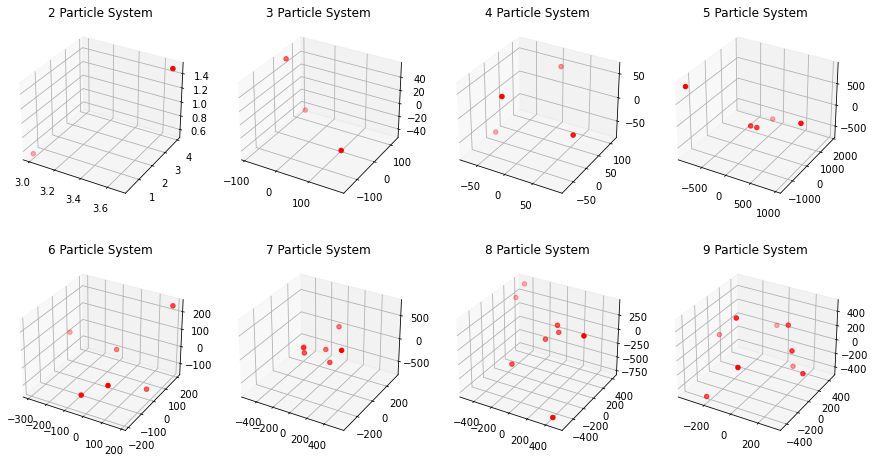

In [28]:
# Get names of all configurations available
file_names = ['Xstart2', 'Xstart3', 'Xstart4', 'Xstart5', 'Xstart6', 'Xstart7', 'Xstart8', 'Xstart9']

# Define two particle optimum, (g) and (h) agreed on the first three numbers after the decimals 3.817
r0 = 3.817

# Make a figure
fig, ax = plt.subplots(ncols=4,nrows=2,figsize=(15,8),subplot_kw=dict(projection='3d'))
ax = ax.flatten()

# Lets investigate on at a time and see if it stops converging
for i in range(len(file_names)):

    # Get positions
    Xstart = data[file_names[i]]
    
    # Number of particles
    N = i+2
    
    # Use BFGS
    x, calls, conv = BFGS(flat_V, flat_gradV, Xstart, tol=1e-10)
    pos_mat = x.reshape(N,-3)
    print(f'\nFor {i+1} particles the functions used {calls} calls to the functions. Converged status: {conv}')
    # If converged calculate distances
    if conv:
        dist_mat = distance(pos_mat)
        
        # Count distances within 1% of 2 particle optimum r0
        N_1procent = sum(abs(dist_mat-r0)/r0 <= 0.01)
        print(f'For {N} particles, {N_1procent} distances were within 1% of the two particle optimum {r0}')
        
        # Plot stuff
        ax[i].scatter(pos_mat[:,0], pos_mat[:,1], pos_mat[:,2], color='r')
        ax[i].set_title(f'{i+2} Particle System')

## J(1) BFGS with line search

In [29]:
def BFGS_line_search(f, gradf, x0, tol=1e-6, max_it=10000):
    
    # Initial guess of the positions
    x = x0
    
    # Define identity matrix of appropriate size
    I = np.eye(len(x0))
    
    # Initialise inverted Hessian approximation with I
    B_inv = I
    
    # Initial gradient
    y = gradf(x)

    # Start counter of calls to the functions f and gradf with 1
    n_calls = 1
    
    # Let the converged status be true. If max_it is hit we change this to false.
    converged = True

    # Start loop, should stop when max_it is reached or at convergence
    # Convergence is chosen to be the norm since a small norm means a small step
    while np.linalg.norm(y) > tol and n_calls < max_it: 
        
        # Get direction from steepest descent
        p = - np.dot(B_inv,y)
        
        # Get alpha from line search in interval -1 to 1
        f_1D = line_function(f, x, p)
        alpha, extra_calls = golden_section_min(f_1D, -1, 1, tol=1e-6)
        n_calls += extra_calls
        
        # Get the next positions
        x_new = x + alpha * p
        
        # Get the displacement
        s = x_new - x
        
        # Get the new gradient and update n_calls
        y_new = gradf(x_new)
        dy = y_new - y 
        n_calls += 1
        
        # Get the new approximation to the inverse hessian (formula from section "algortihm" here:
        # https://en.wikipedia.org/wiki/Broyden–Fletcher–Goldfarb–Shanno_algorithm)
        ro = 1.0 / (np.dot(dy, s))
        A1 = I - ro * s[:, np.newaxis] * dy[np.newaxis, :]
        A2 = I - ro * dy[:, np.newaxis] * s[np.newaxis, :]
        B_inv_new = np.dot(A1, np.dot(B_inv, A2)) + (ro * s[:, np.newaxis] * s[np.newaxis, :])
        
        # Update B_inv, x and y to be the newly found values
        B_inv, x, y = B_inv_new, x_new, y_new
    
    # Update convergence status
    if n_calls >= max_it:
        converged = False
    
    # X coordinates at minimum
    x_opt = x
    
    return x_opt, n_calls, converged

In [30]:
# Load test data
data = np.load("ArStart.npz")    
Xstart2 = data["Xstart2"] # Notice this is already flattened

# Use the BFGS method to find positions
x, calls, conv = BFGS(flat_V, flat_gradV, Xstart2, tol=1e-6, max_it=100)
positions2 = x.reshape(2,-3)
print(f'Minimum found with positions at x0={positions2[0]} and x1={positions2[1]} with {calls} calls to the functions. Converged status {conv}')

# Find the distance between the two particles
distances2 = distance(positions2)
print(f'\nThe minimal energy distance found to be {distances2[0,1]} in correspondance with result in (g)')

Minimum found with positions at x0=[3.68186699 3.93837516 1.48584684] and x1=[3.00028518 0.30055214 0.55046137] with 7 calls to the functions. Converged status True

The minimal energy distance found to be 3.817493425601058 in correspondance with result in (g)



For 1 particles the functions used 35 calls to the functions. Converged status: True
For 2 particles, 2 distances were within 1% of the two particle optimum 3.817

For 2 particles the functions used 375 calls to the functions. Converged status: True
For 3 particles, 6 distances were within 1% of the two particle optimum 3.817

For 3 particles the functions used 681 calls to the functions. Converged status: True
For 4 particles, 12 distances were within 1% of the two particle optimum 3.817

For 4 particles the functions used 1973 calls to the functions. Converged status: True
For 5 particles, 18 distances were within 1% of the two particle optimum 3.817

For 5 particles the functions used 1905 calls to the functions. Converged status: True
For 6 particles, 24 distances were within 1% of the two particle optimum 3.817

For 6 particles the functions used 12887 calls to the functions. Converged status: True
For 7 particles, 30 distances were within 1% of the two particle optimum 3.817

Fo

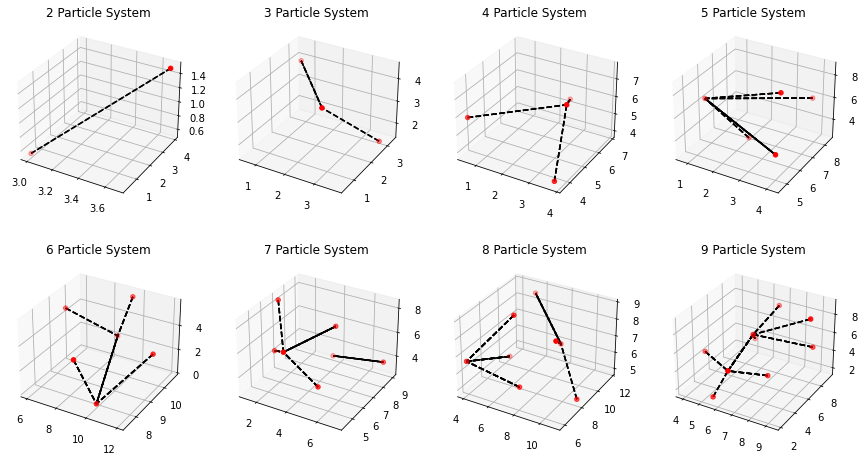

In [31]:
# Get names of all configurations available
file_names = ['Xstart2', 'Xstart3', 'Xstart4', 'Xstart5', 'Xstart6', 'Xstart7', 'Xstart8', 'Xstart9']

# Define two particle optimum, (g) and (h) agreed on the first three numbers after the decimals 3.817
r0 = 3.817

# Make a figure
fig, ax = plt.subplots(ncols=4,nrows=2,figsize=(15,8),subplot_kw=dict(projection='3d'))
ax = ax.flatten()

# Lets investigate on at a time and see if it stops converging
for i in range(len(file_names)):

    # Get positions
    Xstart = data[file_names[i]]
    
    # Number of particles
    N = i+2
    
    # Use BFGS
    x, calls, conv = BFGS_line_search(flat_V, flat_gradV, Xstart, tol=1e-5, max_it=100000)
    pos_mat = x.reshape(N,-3)
    print(f'\nFor {i+1} particles the functions used {calls} calls to the functions. Converged status: {conv}')
    # If converged calculate distances
    if conv:
        dist_mat = distance(pos_mat)
        
        # Count distances within 1% of 2 particle optimum r0
        N_1procent = sum(abs(dist_mat-r0)/r0 <= 0.01)
        print(f'For {N} particles, {N_1procent} distances were within 1% of the two particle optimum {r0}')
        
        # Plot particle positions and set title
        ax[i].scatter(pos_mat[:,0], pos_mat[:,1], pos_mat[:,2], color='r')
        ax[i].set_title(f'{i+2} Particle System')
        
        # Mark particle pairs with the two particle optimum distance between them
        
        # Get a matrix mask that shows True for distances wihtin 1 procent
        mask_mat = (abs(dist_mat-r0)/r0 <= 0.01)
        
        # Analyse one row at a time
        for j in range(N):
            
            # Coordinates for particle i
            particle_A = pos_mat[j,:]
            particle_other = pos_mat[ mask_mat[j,:], : ] 
            
            for k in range(len(particle_other)):
                
                xs = np.array([particle_A[0],particle_other[0][0]])
                ys = np.array([particle_A[1],particle_other[0][1]])
                zs = np.array([particle_A[2],particle_other[0][2]])
                ax[i].plot(xs,ys,zs,color='black', linestyle='dashed')